In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [215]:
df = pd.read_csv("cleaner_data.csv")
print(df.size)
df.head()

88767


,Unnamed: 0,name,multiverse_id,color_identity,text,flavor,power
0,1,Ancestor's Chosen,NaN,['W'],First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4
1,2,Angel of Mercy,129465.0,['W'],Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3
2,4,Angelic Blessing,129711.0,['W'],Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN
3,6,Angelic Chorus,129710.0,['W'],Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN
4,7,Angelic Wall,129671.0,['W'],Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0


In [216]:
import re

def clean_color(text):
     # as cores são branco(W), preto(B), azul(U), vermelho(R) ou verde(G)
    pattern = r"\['(W|B|U|R|G)'\]"
    
    match = re.search(pattern, text)
    
    if match:
        return match.group(1)
    return None

df["color"] = df["color_identity"].apply(clean_color)
df.drop("color_identity", axis=1, inplace = True)

In [217]:
df["color"].value_counts()

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64

In [218]:
df["counterspell"] = (df.text.str.contains(r"[Cc]ounter\s(?:it|target|all)") & # anulações
         (df.text.str.contains(r"[wW]ard(?:\s{|—])") == False)) # Ward é uma maneira de anulação/proteção mais transversal às cores e é ignorada


df["exile"] = (df.text.str.contains(r"[eE]xile\s(?:target|each|all|the|up\sto)") & # exilar algo do tablueiro
        (df.text.str.contains(r"the\stop") == False)) # Algumas cartas "compram" cartas exilando-as do topo do deck, isso nào conta como exilar algo do tabuleiro

df["fight"] = (df.text.str.contains(r"[Ff]ights")) # Criaturas lutarem é uma mecânica característica do verde


df["mill"] = (df.text.str.contains(r"[mM]ill")) # TODO: mill é uma palavra chave recente, antes era referida por descartar a carta do >TOPO DO BATALHO<, bom adicionar este texto também


df["scry"] = (df.text.str.contains(r"[sS]cry"))


df["tap"] = (df.text.str.contains(r"(?:\st|T)ap\s(?:it|target|each|all|or\suntap)")) # cartas que viram outras 


df["untap"] = (df.text.str.contains(r"[uU]ntap\s(?:it|target|each|all)")) # find untappers

"""
df.loc[df.text.str.contains("[dD]eathtouch") | # find creatures that have deathtouch
        df.text.str.contains("deals combat damage to a creature, destroy that creature", regex = False)] # or that have "derptouch"
"""

df["double_strike"] = (df.text.str.contains(r"[dD]ouble\sstrike"))


df["first_strike"] = (df.text.str.contains(r"[fF]irst\sstrike"))


df["flash"] = (df.text.str.contains(r"(?:f|\nF|^F)lash") & # some engineering to avoid incorrectly grabbing cards with Flash in the name
        (df.text.str.contains(r"[fF]lashback") == False)) # dont' want to capture flashback


df["flying"] = (df.text.str.contains(r"[fF]lying"))


df["haste"] = (df.text.str.contains(r"[hH]aste"))


df["hexproof"] = (df.text.str.contains(r"[hH]exproof"))


df["indestructible"] = (df.text.str.contains(r"[iI]ndestructible") &
                         (df.text.str.contains(r"loses\sindestructible") == False))


df["sacrifice"] = (df.text.str.contains(r"[sS]acrifice"))


df["lifelink"] = (df.text.str.contains(r"[lL]ifelink"))


df["menace"] = (df.text.str.contains(r"[mM]enace"))


df["protection"] = (df.text.str.contains(r"[pP]rotection\sfrom"))


df["prowess"] = (df.text.str.contains(r"[pP]rowess"))


df["reach"] = (df.text.str.contains(r"(?:\sr|\nR|^R)each") &
        (df.text.str.contains(r"can't be blocked except by creatures with flying or reach", regex = False) == False)) # don't want flying reminder text


df["trample"] = (df.text.str.contains(r"[tT]rample"))


df["vigilance"] = (df.text.str.contains(r"[vV]igilance"))


df["draw"] = (df.text.str.contains(r"(?:\sd|\nD|^D)raw"))


df["discard"] = (df.text.str.contains(r"[dD]iscard"))


df["damage"] = (df.text.str.contains(r"deals\s\d\sdamage"))


df["damage_prevention"] = (df.text.str.contains(r"[pP]revent\s"))


df["life_gain"] = (df.text.str.contains(r"gain(?:\s|s\s)\d+\slife"))


df["life_loss"] = (df.text.str.contains(r"loses") & 
                   df.text.str.contains(r"(?:their|\d+)\slife")) # capture both fixed and rational values


df["tokens"] = (df.text.str.contains(r"[cC]reate"))


df["destroy"] = (df.text.str.contains(r"[dD]estroy") &
                  (df.text.str.contains(r"don't\sdestroy\sit.") == False)) # reject indestructible's reminder text


df["return"] = (df.text.str.contains(r"[rR]eturn") &
        df.text.str.contains(r"owner's\s(?:hand|library)") & # capture hand or library bounce effects
        (df.text.str.contains(r"graveyard\sto") == False)) # exclude grave recursion


df["recursion"] = (df.text.str.contains(r"\sput|return") &
        df.text.str.contains(r"graveyard")&
        df.text.str.contains(r"hand|battlefield"))

In [219]:
df.head()

,Unnamed: 0,name,multiverse_id,text,flavor,power,color,counterspell,exile,fight,...,draw,discard,damage,damage_prevention,life_gain,life_loss,tokens,destroy,return,recursion
0,1,Ancestor's Chosen,NaN,First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2,Angel of Mercy,129465.0,Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,4,Angelic Blessing,129711.0,Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,Angelic Chorus,129710.0,Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7,Angelic Wall,129671.0,Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [220]:
# Exibir todas as colunas e amostras de valores únicos em texto
print("\nNomes das colunas e valores únicos:")
for coluna in df.columns:
    print(f"\nColuna: {coluna}")
    print(df[coluna].unique())


Nomes das colunas e valores únicos:

Coluna: Unnamed: 0
[    1     2     4 ... 76228 76231 76232]

Coluna: name
["Ancestor's Chosen" 'Angel of Mercy' 'Angelic Blessing' ...
 'Vastwood Fortification // Vastwood Thicket' 'Veteran Adventurer'
 'Vine Gecko']

Coluna: multiverse_id
[    nan 129465. 129711. ... 491866. 491869. 491870.]

Coluna: text
["First strike (This creature deals combat damage before creatures without first strike.)\r\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."
 'Flying\r\nWhen Angel of Mercy enters the battlefield, you gain 3 life.'
 "Target creature gets +3/+3 and gains flying until end of turn. (It can't be blocked except by creatures with flying or reach.)"
 ... 'When Turntimber Ascetic enters the battlefield, you gain 3 life.'
 'Veteran Adventurer is also a Cleric, Rogue, Warrior, and Wizard.\r\nThis spell costs {1} less to cast for each creature in your party.\r\nVigilance'
 'The first kicked spell you cast ea

In [221]:
# Certifique-se de que os dados estão em formato de string antes de processar
df["flavor"] = df["flavor"].astype(str)  # Converte para string, caso não esteja

# Definir stop words
stop_words = set(stopwords.words("english"))  # Necessário baixar as stop words antes

print(stop_words)
stop_words.add('one')

# Define a função de preprocessamento
def preprocess(text, stop_words):
    # Remove pontuação e converte para minúsculas
    text = re.sub(r'[^\w\s]', '', text.lower())  
    # Tokeniza o texto
    tokens = word_tokenize(text)
    print(tokens)
    # Remove as stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]  
    return filtered_tokens

# Aplica a função a cada linha da coluna 'flavor'
df["processed_flavor"] = df["flavor"].apply(lambda x: preprocess(x, stop_words))

# Mostra o resultado
print(df)

{"aren't", 'why', 'down', 'doing', 'with', "she's", 'no', 'll', 'but', 'having', 'mightn', 'itself', "isn't", 'aren', "didn't", 'he', "weren't", 'any', 'am', 'don', 'over', 'couldn', 'ours', 'needn', 'more', 'has', 'weren', 'did', 'them', 'at', 'most', 'a', 'they', 'we', 'yourself', "needn't", 'before', 'had', 'there', 'off', 'nor', 'above', 'herself', 'hasn', 'its', 'than', 'my', 'me', 'ourselves', 're', 'and', 'by', 'himself', 'the', 'do', 'her', "you'll", 'how', 'through', 'ain', 'will', 'doesn', 'being', 'if', 'both', 'now', 'that', 'here', 'own', 'too', 'wouldn', 'who', 'these', "that'll", 'she', 'where', 'theirs', "hasn't", 'wasn', 'his', 'to', 'just', "it's", "mustn't", 'in', 'have', 'shan', "shouldn't", "don't", 'of', 'during', 'myself', 'such', 'are', 'once', 'can', 'your', 'then', 'is', 'yourselves', 'about', 'i', 't', 'y', "you'd", 'each', 'our', 'again', 'd', 'be', 'only', "haven't", 'very', 'isn', "mightn't", 'should', 'o', 'under', "couldn't", 'haven', 'below', 'as', 'unt

In [222]:
# Junta as palavras por cor única
df_grouped = df.groupby('color')['flavor'].apply(lambda x: ' '.join(x)).reset_index()

# Inicializa o TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Ajusta e transforma os textos agregados por cor
tfidf_matrix = vectorizer.fit_transform(df_grouped['flavor'])

# Converte a matriz TF-IDF para um DataFrame para visualização
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_grouped['color']  # Define as cores únicas como índice
)

# Exibe o DataFrame TF-IDF
print(tfidf_df)

            000       070       071        10       100      1008        11  \
color                                                                         
B      0.002239  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
G      0.000000  0.000000  0.000000  0.000000  0.003190  0.000000  0.000000   
R      0.002370  0.004206  0.004206  0.000000  0.000000  0.000000  0.004206   
U      0.012631  0.000000  0.000000  0.004484  0.007235  0.000000  0.000000   
W      0.002235  0.000000  0.000000  0.000000  0.000000  0.003967  0.000000   

          115th        12        13  ...   zzzyxas  äagesdotter    ærathi  \
color                                ...                                    
B      0.003974  0.000000  0.000000  ...  0.003974     0.006412  0.000000   
G      0.000000  0.003190  0.003954  ...  0.000000     0.000000  0.000000   
R      0.000000  0.003394  0.000000  ...  0.000000     0.000000  0.004206   
U      0.000000  0.000000  0.000000  ...  0.000000     0.0217

In [223]:
# Empilhar os dados para todas as cores e palavras
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']

# Ordenar os dados por TF-IDF de forma decrescente
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)

# Exibir o top 20
print(top_tfidf_all)


      color     word     tfidf
3587      B    death  0.335136
23208     G   forest  0.261917
8775      B     life  0.215850
43658     R     like  0.210453
78506     W    light  0.204169
61088     U     like  0.198704
3567      B     dead  0.196916
27460     G   nature  0.190314
41202     R  goblins  0.188405
65496     U      sea  0.188021
43002     R     just  0.186401
67784     U     time  0.183747
1603      B    blood  0.179875
61859     U     mind  0.177338
26205     G     life  0.167702
78495     W     life  0.164469
26228     G     like  0.160165
86466     W      war  0.158798
60432     U     just  0.153835
8798      B     like  0.151474


In [224]:
# Empilhar os dados para todas as cores e palavras
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']

# Ordenar os dados por TF-IDF de forma decrescente para pegar as 20 palavras mais relevantes
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)

# Pegar as 20 palavras mais relevantes
top_20_words = top_tfidf_all['word'].unique()

# Filtrar a matriz TF-IDF para as 20 palavras mais relevantes
filtered_tfidf = tfidf_df[top_20_words]

# Exibir o TF-IDF das 20 palavras para as 5 cores específicas
top_20_tfidf = filtered_tfidf.loc[df['color'].unique()[:5]]  # Aqui você pode ajustar o número de cores ou selecionar específicas
print(top_20_tfidf)



          death    forest      life      like     light      dead    nature  \
color                                                                         
W      0.103975  0.005671  0.164469  0.120989  0.204169  0.056714  0.009452   
U      0.053415  0.008546  0.076918  0.198704  0.029912  0.032049  0.036322   
B      0.335136  0.007574  0.215850  0.151474  0.043549  0.196916  0.028401   
R      0.072155  0.006013  0.070151  0.210453  0.034073  0.048103  0.026056   
G      0.082909  0.261917  0.167702  0.160165  0.032033  0.033917  0.190314   

        goblins       sea      just      time     blood      mind       war  
color                                                                        
W      0.011343  0.015124  0.090742  0.102084  0.049152  0.030247  0.158798  
U      0.017093  0.188021  0.153835  0.183747  0.021366  0.177338  0.047005  
B      0.009467  0.026508  0.145794  0.094671  0.179875  0.081417  0.053016  
R      0.188405  0.024052  0.186401  0.096207  0.126272 

In [225]:
# Calcular a soma dos valores de TF-IDF para cada palavra
tfidf_sum = tfidf_df.sum(axis=0)

# Identificar palavras a remover: TF-IDF > 0.1 em todas as cores e soma > 0.6
words_to_remove = []

for word in tfidf_df.columns:
    if all(tfidf_df[word] > 0.1) and tfidf_sum[word] > 0.6:
        words_to_remove.append(word)

# Função para remover as palavras da lista
def remove_words(flavor_list, words_to_remove):
    return [word for word in flavor_list if word not in words_to_remove]
            
words_to_remove.append('color')
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

# Aplicar a função à coluna 'processed_flavor'
df['processed_flavor'] = df['processed_flavor'].apply(lambda x: remove_words(x, words_to_remove))

# Exibir as palavras removidas
print("Palavras removidas:", words_to_remove)


Palavras removidas: ['like', 'color']


In [226]:
import pandas as pd

# Calcular a soma dos valores de TF-IDF para cada palavra
tfidf_sum = filtered_tfidf_df.sum(axis=0)

# Identificar palavras a remover: TF-IDF > 0.1 em todas as cores e soma > 0.6
words_to_remove = []

for word in filtered_tfidf_df.columns:
    if all(filtered_tfidf_df[word] > 0.1) and tfidf_sum[word] > 0.6:
        words_to_remove.append(word)

# Remover as palavras identificadas
filtered_tfidf_df_df = filtered_tfidf_df.drop(columns=words_to_remove)

# Agora, reorganizar as palavras em uma coluna, mantendo as cores nas linhas
# "melt" transforma as colunas em uma única coluna de palavras e uma coluna de cores
melted_df = filtered_tfidf_df.reset_index().melt(id_vars=['color'], var_name='word', value_name='tfidf_value')

# Remover as linhas com valor de TF-IDF 0 (não precisam ser exibidas)
melted_df = melted_df[melted_df['tfidf_value'] > 0]

# Exibir o DataFrame reorganizado
print(melted_df.head())


  color word  tfidf_value
0     B  000     0.002239
2     R  000     0.002370
3     U  000     0.012631
4     W  000     0.002235
7     R  070     0.004206


In [227]:

# Codigo bem rudimentar -> não usa o pmi(?) e tira manualmente as stopwords

def make_word_map(col, df):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in df[col]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

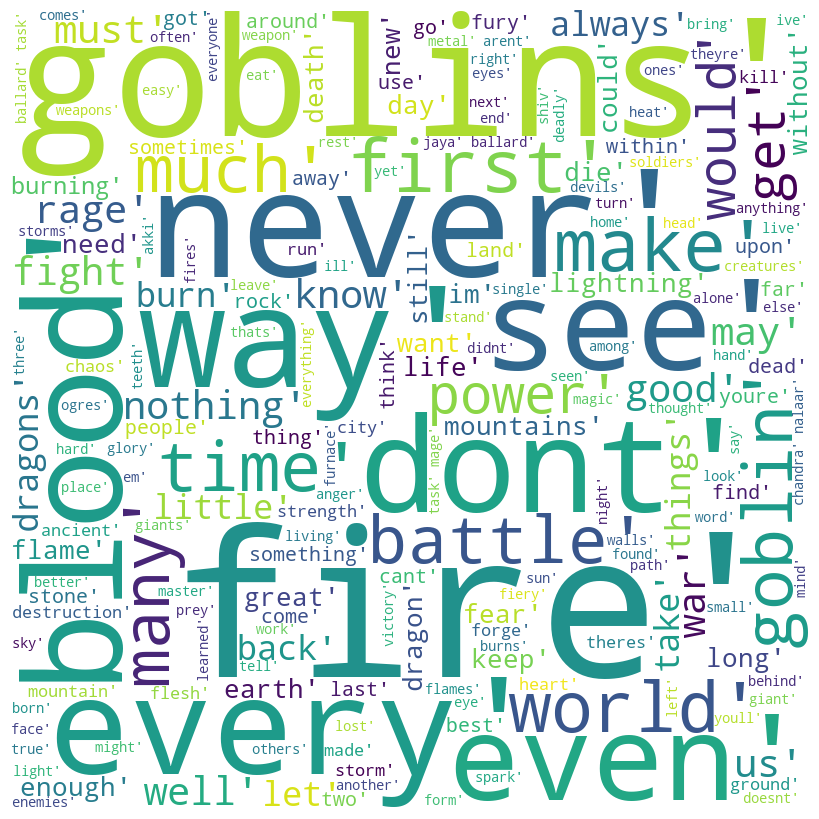

In [231]:
color = "R"
df_cor = df[df["color"] == color]

make_word_map("processed_flavor", df_cor)